In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [72]:
plt.rcParams["figure.figsize"] = (15,5)

In [73]:

def least_squares(x, y):
    if np.linalg.det(x.T @ x) != 0:
        return np.linalg.inv((x.T @ x)) @ (x.T @ y)
    return np.linalg.pinv((x.T @ x)) @ (x.T @ y) 
"""
Autoregressor
"""
def ar_process(eps, phi):
    """
    Creates a AR process with a zero mean.
    """
    # Reverse the order of phi and add a 1 for current eps_t
    phi = np.r_[1, phi][::-1]
    ar = eps.copy()
    offset = len(phi)
    for i in range(offset, ar.shape[0]):
        ar[i - 1] = ar[i - offset: i] @ phi
    return ar


"""
Moving Average 
"""
n = 500
eps = np.random.normal(size=n)

def lag_view(x, order):
    """
    For every value X_i create a row that lags k values: [X_i-1, X_i-2, ... X_i-k]
    """
    y = x.copy()
    # Create features by shifting the window of `order` size by one step.
    # This results in a 2D array [[t1, t2, t3], [t2, t3, t4], ... [t_k-2, t_k-1, t_k]]
    x = np.array([y[-(i + order):][:order] for i in range(y.shape[0])])

    # Reverse the array as we started at the end and remove duplicates.
    # Note that we truncate the features [order -1:] and the labels [order]
    # This is the shifting of the features with one time step compared to the labels
    x = np.stack(x)[::-1][order - 1: -1]
    y = y[order:]

    return x, y

def ma_process(eps, theta):
    """
    Creates an MA(q) process with a zero mean (mean not included in implementation).
    :param eps: (array) White noise signal.
    :param theta: (array/ list) Parameters of the process.
    """
    # reverse the order of theta as Xt, Xt-1, Xt-k in an array is Xt-k, Xt-1, Xt.
    theta = np.array([1] + list(theta))[::-1][:, None]
    eps_q, _ = lag_view(eps, len(theta))
    return eps_q @ theta


"""
Differencing 
"""
def difference(x, d=1):
    if d == 0:
        return x
    else:
        x = np.r_[x[0], np.diff(x)]
        return difference(x, d - 1)

def undo_difference(x, d=1):
    if d == 1:
        return np.cumsum(x)
    else:
        x = np.cumsum(x)
        return undo_difference(x, d - 1)


"""
Linear Regression
"""
class LinearModel:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
        self.beta = None
        self.intercept_ = None
        self.coef_ = None

    def _prepare_features(self, x):
        if self.fit_intercept:
            x = np.hstack((np.ones((x.shape[0], 1)), x))
        return x

    def fit(self, x, y):
        x = self._prepare_features(x)
        self.beta = least_squares(x, y)
        if self.fit_intercept:
            self.intercept_ = self.beta[0]
            self.coef_ = self.beta[1:]
        else:
            self.coef_ = self.beta

    def predict(self, x):
        x = self._prepare_features(x)
        return x @ self.beta

    def fit_predict(self, x, y):
        self.fit(x, y)
        return self.predict(x)


"""
ARIMA Model 
"""
class ARIMA(LinearModel):
    def __init__(self, q, d, p):
        """
        An ARIMA model.
        :param q: (int) Order of the MA model.
        :param p: (int) Order of the AR model.
        :param d: (int) Number of times the data needs to be differenced.
        """
        super().__init__(True)
        self.p = p
        self.d = d
        self.q = q
        self.ar = None
        self.resid = None

    def prepare_features(self, x):
        if self.d > 0:
            x = difference(x, self.d)

        ar_features = None
        ma_features = None

        # Determine the features and the epsilon terms for the MA process
        if self.q > 0:
            if self.ar is None:
                self.ar = ARIMA(0, 0, self.p)
                self.ar.fit_predict(x)
            eps = self.ar.resid
            eps[0] = 0

            # prepend with zeros as there are no residuals_t-k in the first X_t
            ma_features, _ = lag_view(np.r_[np.zeros(self.q), eps], self.q)

        # Determine the features for the AR process
        if self.p > 0:
            # prepend with zeros as there are no X_t-k in the first X_t
            ar_features = lag_view(np.r_[np.zeros(self.p), x], self.p)[0]

        if ar_features is not None and ma_features is not None:
            n = min(len(ar_features), len(ma_features))
            ar_features = ar_features[:n]
            ma_features = ma_features[:n]
            features = np.hstack((ar_features, ma_features))
        elif ma_features is not None:
            n = len(ma_features)
            features = ma_features[:n]
        else:
            n = len(ar_features)
            features = ar_features[:n]

        return features, x[:n]

    def fit(self, x):
        features, x = self.prepare_features(x)
        super().fit(features, x)
        return features

    def fit_predict(self, x):
        """
        Fit and transform input
        :param x: (array) with time series.
        """
        features = self.fit(x)
        return self.predict(x, prepared=(features))

    def predict(self, x, **kwargs):
        """
        :param x: (array)
        :kwargs:
            prepared: (tpl) containing the features, eps and x
        """
        features = kwargs.get('prepared', None)
        if features is None:
            features, x = self.prepare_features(x)

        y = super().predict(features)
        self.resid = x - y

        return self.return_output(y)

    def return_output(self, x):
        if self.d > 0:
            x = undo_difference(x, self.d)
        return x

    def forecast(self, x, n):
        """
        Forecast the time series.
        :param x: (array) Current time steps.
        :param n: (int) Number of time steps in the future.
        """
        features, x = self.prepare_features(x)
        y = super().predict(features)

        # Append n time steps as zeros. Because the epsilon terms are unknown
        y = np.r_[y, np.zeros(n)]
        for i in range(n):
            feat = np.r_[y[-(self.p + n) + i: -n + i], np.zeros(self.q)]
            y[x.shape[0] + i] = super().predict(feat[None, :])
        return self.return_output(y)

In [74]:
dayn1 = pd.read_csv('./data/prices_round_2_day_-1.csv', sep=';')
day0 = pd.read_csv('./data/prices_round_2_day_0.csv', sep=';')
day1 = pd.read_csv('./data/prices_round_2_day_1.csv', sep=';')
# dayn1.head()
# day0.head()
# day1.head()

In [75]:
df_all = pd.concat([dayn1, day0, day1], axis=0)
df_all.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-1,0,PEARLS,10002,1,9996.0,2.0,9995.0,29.0,10004,2,10005.0,29.0,NaN,NaN,10003.0,0.0
1,-1,0,PINA_COLADAS,14999,38,14998.0,53.0,NaN,NaN,15001,38,15002.0,53.0,NaN,NaN,15000.0,0.0
2,-1,0,COCONUTS,7999,162,NaN,NaN,NaN,NaN,8001,55,8002.0,107.0,NaN,NaN,8000.0,0.0
3,-1,0,BANANAS,4951,1,4946.0,2.0,4945.0,29.0,4952,31,NaN,NaN,NaN,NaN,4951.5,0.0
4,-1,100,PEARLS,9996,2,9995.0,22.0,NaN,NaN,10004,2,10005.0,22.0,NaN,NaN,10000.0,4.0


In [76]:
bdf = df_all[df_all['product'] == 'BANANAS']
bdf.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
3,-1,0,BANANAS,4951,1,4946.0,2.0,4945.0,29.0,4952,31,NaN,NaN,NaN,NaN,4951.5,0.000000
7,-1,100,BANANAS,4945,24,NaN,NaN,NaN,NaN,4952,24,NaN,NaN,NaN,NaN,4948.5,3.444336
9,-1,200,BANANAS,4945,20,NaN,NaN,NaN,NaN,4952,20,NaN,NaN,NaN,NaN,4948.5,3.795410
15,-1,300,BANANAS,4945,31,NaN,NaN,NaN,NaN,4952,31,NaN,NaN,NaN,NaN,4948.5,3.604004
19,-1,400,BANANAS,4945,27,NaN,NaN,NaN,NaN,4952,27,NaN,NaN,NaN,NaN,4948.5,3.337402


In [77]:
spreads = {}
imbalances = {}

for i, row in bdf.iterrows():
    bstr = 'bid_price_'
    astr = 'ask_price_'

    best_bid = 0
    b_qty = 0
    best_ask = 10000
    a_qty = 0

    for j in range(1, 4):
        if math.isnan(row[bstr + str(j)]):
            break
        if best_bid < row[bstr + str(j)]:
            best_bid = row[bstr + str(j)]
            b_qty = row['bid_volume_' + str(j)]

    for j in range(1, 4):
        if math.isnan(row[astr + str(j)]):
            break
        if best_ask > row[astr + str(j)]:
            best_ask = row[astr + str(j)]
            a_qty = row['ask_volume_' + str(j)]
    
    imbalance = round(b_qty / (b_qty + a_qty))
    spread = best_ask - best_bid

    imbalances.update({imbalance: 0})
    spreads.update({spread: 0})

In [78]:
print(imbalances)
print(len(imbalances))
print(spreads)
print(len(spreads))

{0: 0, 1: 0}
2
{1: 0, 7: 0, 5: 0, 6: 0, 4: 0, 2: 0, 3: 0}
7


In [79]:
bananas = np.concatenate((dayn1[dayn1['product'] == 'BANANAS']['mid_price'], day0[day0['product'] == 'BANANAS']['mid_price'], day1[day1['product'] == 'BANANAS']['mid_price']))
print(bananas)
print(len(bananas))

[4951.5 4948.5 4948.5 ... 4820.5 4824.  4823.5]
30000


In [80]:
x = np.arange(0, 30000 * 100, 1)
x100 = np.arange(0, 30000 * 100, 100)

In [81]:
# gridsearch
hist_len = 5

for d in range(0, 2):
    for q in range(0, 6):
        for p in range(1, 3):
            model = ARIMA(q, d, p)

            predictions = np.append(bananas[0:hist_len], np.zeros(30000 - hist_len))

            for i in range(hist_len, 30000):
                pred = model.fit_predict(bananas[i - hist_len:i])
                forecast = model.forecast(pred, 1)
                predictions[i] = forecast[-1]
            
            mse = np.sum(np.power(predictions - bananas, 2)) / 30000
            
            print(f'ARIMA(p = {p}, q = {q}, d = {d}) => mse = {mse}')

ARIMA(p = 1, q = 0, d = 0) => mse = 1.9244802694436511


KeyboardInterrupt: 

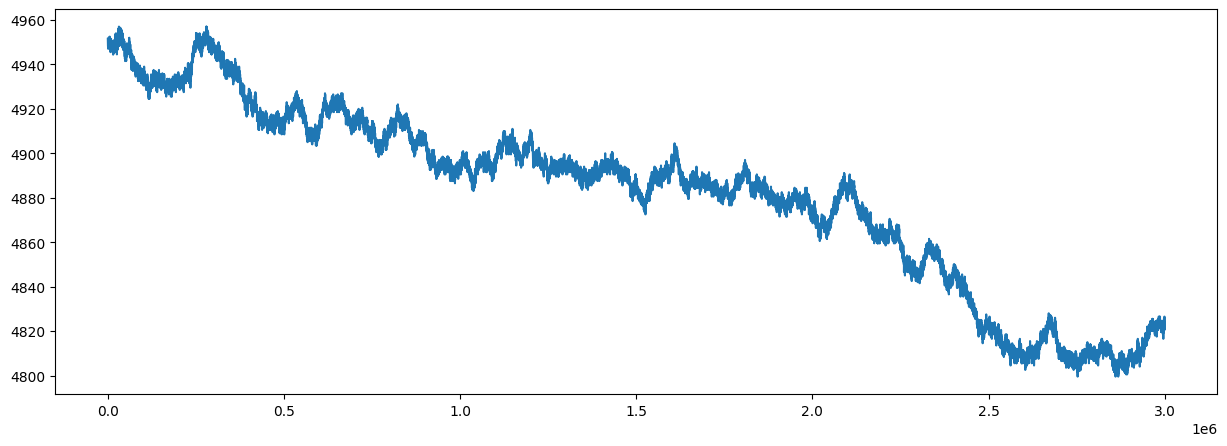

In [88]:
plt.plot(x100, bananas)
# plt.plot(x100, predictions)
# plt.xlim((0, 500000))
# plt.ylim((4940, 4960))
plt.show()